In [ ]:
# Unpacking best-performing text classiffier
# January 2025
# Violeta Berdejo-Espinola

# read data

In [24]:
import mpu
from sklearn.preprocessing import LabelEncoder

# read classification model 

clf = mpu.io.read('../results/model/best_model.pickle')

# raw corpus

corpus_raw = mpu.io.read('../data/corpus_raw.pickle')

x = [' '.join(each_document) for each_document in corpus_raw]

# pos, negs

pos = mpu.io.read('../data/pos.pickle')
neg = mpu.io.read('../data/neg.pickle')
y = [1] * len(pos) + [0] * len(neg)

In [25]:
# calculate weights

weight_for_class_0 = len(x) / (len(neg) * 2) 
weight_for_class_1 = len(x) / (len(pos) * 2) 

# split data

In [26]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42,  test_size=0.20,)

# best performing model


In [27]:
from imblearn.pipeline import Pipeline, make_pipeline 

from embetter.text import SentenceEncoder

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_predict, StratifiedKFold

from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

def train_eval_best_model(x_train, y_train, x_test, y_test, text_length, kfold, random_state):
    """"
    Train and test model
    
    Parameters:
    -----------
    x_train, x_test: list of strings
        raw text to create embeddings
    y_train_y_test: array 
        binary labels
    text_length: string 
        indicating whther it is 'text and asbtract' or 'text, asbtract, and main text'
    kfold: int
        indicating number of folds for cross validation
    embedding_model: string
        instantiation of embedding model
    random_state: int
        seed

        
    Returns:
    --------
    Dictionary with scores.
    Log losss values for test and train set.
    Array of test set predicitons
    """
    
    pipeline = make_pipeline(
        SentenceEncoder('distiluse-base-multilingual-cased-v1'),
        clf

    )

    y_train_pred_cv = cross_val_predict(pipeline, x_train, y_train, cv=StratifiedKFold(kfold), method='predict') 

    pipeline.fit(x_train, y_train)
    
    y_train_pred = pipeline.predict(x_train)

    y_test_pred = pipeline.predict(x_test)

    scores = {
        'Classifier': 'Log_reg',
        'Feature_extraction': 'multilingual embedding model',
        'Weighting': 'Weighted',
        'CV': kfold,
        'Text_length': text_length,
        'Solver': 'Liblinear',
        'F1_tr_cv': round(f1_score(y_train, y_train_pred_cv), 3),
        'F1_tr': round(f1_score(y_train, y_train_pred), 3),
        'F1_ts': round(f1_score(y_test, y_test_pred), 3),
        'Precision_tr_cv': round(precision_score(y_train, y_train_pred_cv), 3),
        'Precision_tr': round(precision_score(y_train, y_train_pred), 3),
        'Precision_ts': round(precision_score(y_test, y_test_pred), 3),
        'Recall_tr_cv': round(recall_score(y_train, y_train_pred_cv), 3),
        'Recall_tr': round(recall_score(y_train, y_train_pred), 3),
        'Recall_ts': round(recall_score(y_test, y_test_pred), 3)
        }
    
    # log loss train set
    y_pred_tr = pipeline.predict_proba(x_train) 
    logloss_tr = log_loss(y_train, y_pred_tr) 

    # log loss test set
    y_pred_ts = pipeline.predict_proba(x_test)  
    logloss_ts = log_loss(y_test, y_pred_ts)
    
    print(f'loss training set: {logloss_tr}, \nloss test set {logloss_ts}')
    print(f'confusion matrix train set:\n{confusion_matrix(y_train, pipeline.predict(x_train))}')
    print(f'confusion matrix test set:\n{confusion_matrix(y_test, pipeline.predict(x_test))}') 
 
    return scores, y_pred_ts, logloss_tr, logloss_ts

In [28]:
scores, y_pre_ts, logloss_tr, logloss_ts = train_eval_best_model(x_train, y_train, x_test, y_test, 'Title_Abstract', 2, 42)

/Users/uqvberde/Projects/classifier_spanish/.venv/lib/python3.11/site-packages/sentence_transformers/models/Dense.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.

loss training set: 0.18121501177699803, 
loss test set 0.19313035009729096
confusion matrix train set:
[[3723  243]
 [   0   49]]
confusion matrix test set:
[[922  69]
 [  1  12]]


# investigating performance on different train-test partitions


In [ ]:
# run on a few different train-test partitions, then report the average with the standard error.
# I should see greater performance with more data, but also lower variance across the different random samples

In [10]:
seeds = [24, 36, 42, 64, 128]

scores = []
logloss_ts =[]

for seed in seeds:
    model_scores, y_pred_ts, logloss_tr, model_logloss_ts = train_eval_best_model(x_train, y_train, x_test, y_test, 'Title_Abstract', 2, seed)
    scores.append(model_scores)
    logloss_ts.append(model_logloss_ts)

/Users/uqvberde/Projects/classifier_spanish/.venv/lib/python3.11/site-packages/sentence_transformers/models/Dense.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.

loss training set: 0.18121501177699803, 
loss test set 0.19313035009729096
confusion matrix train set:
[[3723  243]
 [   0   49]]
confusion matrix test set:
[[922  69]
 [  1  12]]


/Users/uqvberde/Projects/classifier_spanish/.venv/lib/python3.11/site-packages/sentence_transformers/models/Dense.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.

loss training set: 0.18121501177699803, 
loss test set 0.19313035009729096
confusion matrix train set:
[[3723  243]
 [   0   49]]
confusion matrix test set:
[[922  69]
 [  1  12]]


/Users/uqvberde/Projects/classifier_spanish/.venv/lib/python3.11/site-packages/sentence_transformers/models/Dense.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.

loss training set: 0.18121501177699803, 
loss test set 0.19313035009729096
confusion matrix train set:
[[3723  243]
 [   0   49]]
confusion matrix test set:
[[922  69]
 [  1  12]]


/Users/uqvberde/Projects/classifier_spanish/.venv/lib/python3.11/site-packages/sentence_transformers/models/Dense.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.

loss training set: 0.18121501177699803, 
loss test set 0.19313035009729096
confusion matrix train set:
[[3723  243]
 [   0   49]]
confusion matrix test set:
[[922  69]
 [  1  12]]


/Users/uqvberde/Projects/classifier_spanish/.venv/lib/python3.11/site-packages/sentence_transformers/models/Dense.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.

loss training set: 0.18121501177699803, 
loss test set 0.19313035009729096
confusion matrix train set:
[[3723  243]
 [   0   49]]
confusion matrix test set:
[[922  69]
 [  1  12]]


In [22]:
import pandas as pd 
a = pd.DataFrame(scores)
a['seed'] = seeds
a['log_loss'] = logloss_ts
a.columns
a = a[['seed','F1_ts','Precision_ts','Recall_ts','Recall_ts','log_loss']]
a
a.to_csv('../results/model_scores/model_scores_multiple_seeds.csv', encoding='utf-8')

# plot predicted probabilities


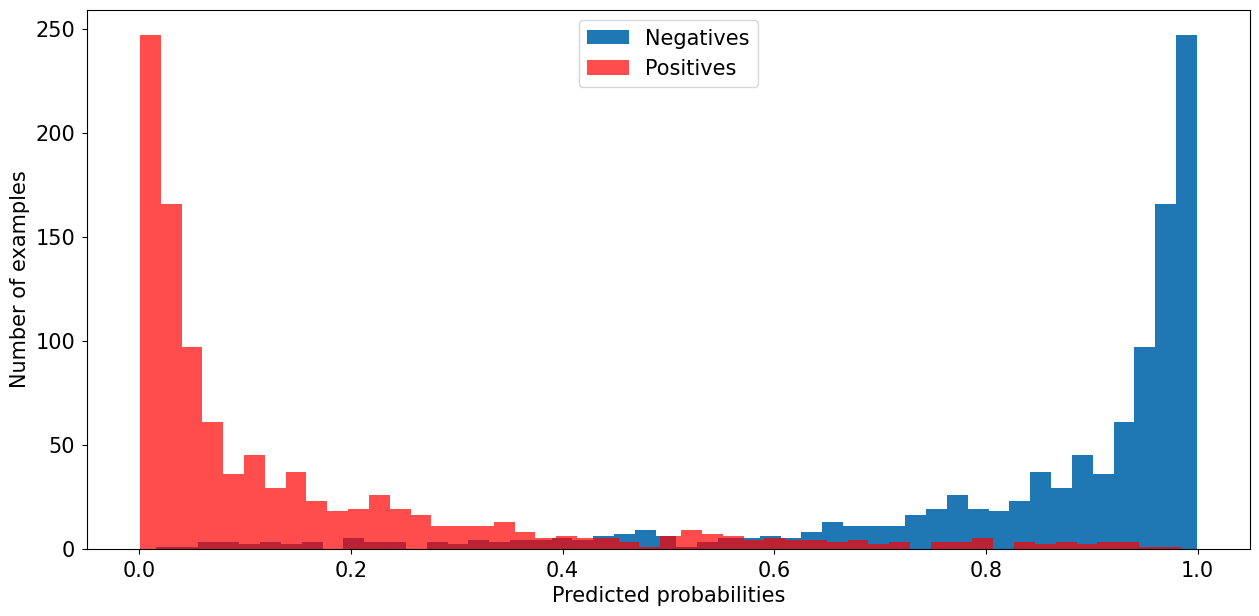

In [37]:
import matplotlib.pyplot as plt

y_pred_ts_p = y_pre_ts[:,1] # subset class of interest --> 1d array
y_pred_ts_n = y_pre_ts[:,0]

plt.figure(figsize=(15,7))
plt.hist(y_pred_ts_n, bins=50, label='Negatives')
plt.hist(y_pred_ts_p, bins=50, label='Positives', alpha=0.7, color='r')
plt.xlabel('Predicted probabilities', fontsize=15)
plt.ylabel('Number of examples', fontsize=15)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=15, pad=5)
plt.savefig('../results/model_scores/predicted_proba_logreg_ts.png', dpi=800)
plt.show() 
